In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# general imports
import sys
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy

from scipy import stats
from scipy.optimize import curve_fit
from statsmodels.stats import multitest
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [3]:
## put your path to your vape repo here 
path_to_vape = os.path.expanduser('~/Documents/code/Vape/')
popoff_path = '/home/jrowland/Documents/code/pop-off/scripts/'

# Bit hacky but oh well
sys.path.append(path_to_vape)
sys.path.append(os.path.join(path_to_vape, 'utils'))
sys.path.append(popoff_path)

from utils.utils_funcs import d_prime

In [4]:
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=sns.color_palette('colorblind'))

def save_figure(name, base_path='/home/jrowland/mnt/qnap/Figures/josh_thesis'):
    plt.rcParams['pdf.fonttype'] = 42
    plt.savefig(os.path.join(base_path, f'{name}.pdf'), 
                bbox_inches='tight', transparent=True)

In [5]:
from matplotlib import rcParams

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

COLORS = [
'#228E5E', # Hit green
'#DB3713', # Miss red
]

## MAKE THE FONT SIZE 20 or 21
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 14


rcParams.update(params)



In [6]:
import utils.utils_funcs as uf
from subsets_analysis import Subsets
import pickle
import popoff

from Session import Session, SessionLite, build_flu_array_single

/home/jrowland/Documents/code/pop-off/popoff/popoff/loadpaths.py
/home/jrowland/Documents/code/Vape


In [36]:
# mouse = 'RL117'
# run_number = 30

# mouse = 'RL117'
# run_number = 29

# mouse = 'RL123'
# run_number = 22

mouse = 'RL116'
run_number = 32


pkl_path = '/home/clean_python/code/Vape/run_pkls/'

In [8]:
# mice = ['RL117', 'RL117', 'RL123']
# run_numbers = [30,29,22]

In [10]:
def load_pupil(mouse, run_number):
    
    qnap_path = '/home/jrowland/mnt/qnap/Data'
    
    if run_number == 29 and mouse=='RL117':
        proc_file = '2021-03-09/2021-03-09_RL117_pupil/2021-03-09_RL117_pupil_proc.npy'
    if run_number == 30 and mouse=='RL117':
        proc_file = '2021-03-10/2021-03-10_RL117_pupil/2021-03-10_RL117_pupil_proc.npy'
    if run_number == 22 and mouse=='RL123':
        proc_file = '2021-03-10/2021-03-10_RL123_pupil/big_cunt_proc.npy'
        
    file_path = os.path.join(qnap_path, proc_file)
    proc = np.load(file_path, allow_pickle=True).item()
    
    
    pupil = proc['pupil'][0]['area_smooth']
    
    return pupil

def mad_point_remover(y, remove_threshold, plot=False):
    # For cutting off the mad points
    to_remove = np.where(y>remove_threshold)[0]
    
    if len(to_remove) > 0:
        Min = np.where(y>remove_threshold)[0][0]
        Max = np.where(y>remove_threshold)[0][-1]
        y[y > remove_threshold] = np.mean((y[Min-20:Min] + y[Max+1:Max+21])/2)
    
    if plot:
        plt.figure(figsize=(15,5))
        plt.plot(y, '.')
        plt.axhline(remove_threshold)
    
    return y


def load_run(mouse, run_number, base_path):
    pkl_path = os.path.join(base_path, mouse, f'run{run_number}.pkl')
    with open(pkl_path, 'rb') as f:
        run = pickle.load(f)
    
    return run

Now loading mouse RL117, run 30
/home/clean_python/code/Vape/run_pkls/RL117/run30.pkl
microcontroller trial starts occur on average nan ms from galvo trial starts
photo stim occurences: {0: 69, 1: 73, 2: 78}
Occurence table:
[[64.  5.]
 [58. 15.]
 [51. 27.]]
204 / 733 cells filtered
STIM RADIUS FOR TARGET REDUCED FIXED IN FUTURE
hfksldjfs
198
197
197 / 197 non nan trials identified
Numbers of PS cells: [  0   5  10  20  30  40  50 150]
Now loading mouse RL117, run 29
/home/clean_python/code/Vape/run_pkls/RL117/run29.pkl
microcontroller trial starts occur on average nan ms from galvo trial starts
photo stim occurences: {0: 119, 1: 119, 2: 94}
Occurence table:
[[95. 24.]
 [56. 63.]
 [24. 70.]]
134 / 611 cells filtered
STIM RADIUS FOR TARGET REDUCED FIXED IN FUTURE
hfksldjfs
266
266
266 / 266 non nan trials identified
Numbers of PS cells: [  0   5  10  20  30  40  50 150]
Now loading mouse RL123, run 22
/home/clean_python/code/Vape/run_pkls/RL123/run22.pkl
microcontroller trial starts occ

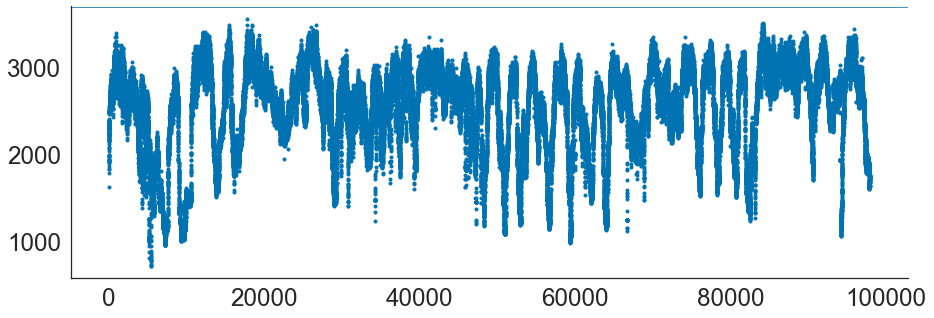

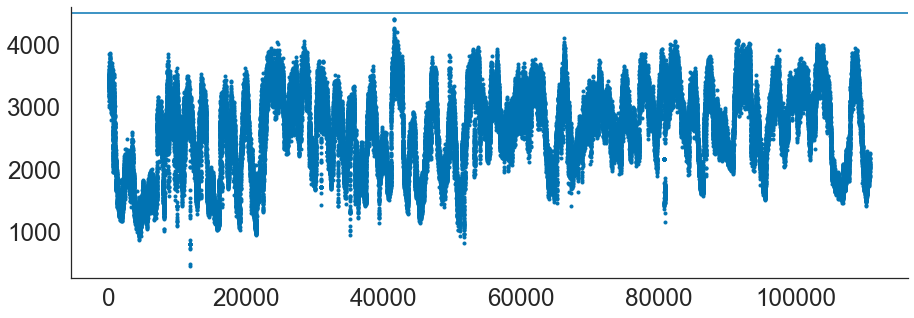

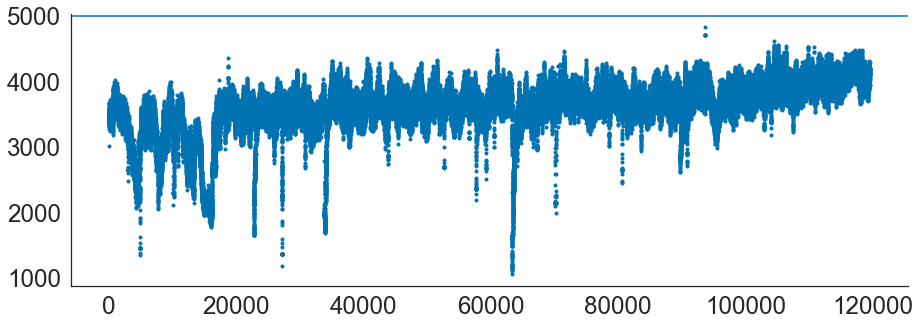

In [152]:
pupils = []
runs = []
sessions = []

for mouse, run_number in zip(mice, run_numbers):
    
    session = SessionLite(mouse, run_number, pkl_path, 'flu', pre_gap_seconds=0, post_gap_seconds=0)
    run = load_run(mouse, run_number, pkl_path)
    
    pupil = load_pupil(mouse, run_number)
    # Find out which recorded triggers were matched to the
    # imaging frames. Assumes that imaging and pupil frames
    # occur at roughly the same time
    idx_imaged = np.isin(run.frame_clock, run.paqio_frames)
    assert sum(idx_imaged) == run.flu.shape[1]
    pupil = pupil[idx_imaged]

    if mouse == 'RL117' and run_number == 30:
        remove_threshold = 3700
    if mouse == 'RL117' and run_number == 29:
        remove_threshold = 4500
    if mouse == 'RL123' and run_number == 22:
        remove_threshold = 5000

    pupil = mad_point_remover(pupil, remove_threshold, plot=True)
    # Add an extra dimension so an array can be built in the same 
    # was as flu
    
    run.pupil = np.expand_dims(pupil, 0)
    
    runs.append(run)
    sessions.append(session)
    pupils.append(pupil)
    

In [41]:
# pupil = load_pupil(mouse, run_number)
run = load_run(mouse, run_number, pkl_path)

In [11]:
# Find out which recorded triggers were matched to the
# imaging frames. Assumes that imaging and pupil frames
# occur at roughly the same time
idx_imaged = np.isin(run.frame_clock, run.paqio_frames)
assert sum(idx_imaged) == run.flu.shape[1]
pupil = pupil[idx_imaged]

if mouse == 'RL117' and run_number == 30:
    remove_threshold = 3700
if mouse == 'RL117' and run_number == 29:
    remove_threshold = 4500
if mouse == 'RL123' and run_number == 22:
    remove_threshold = 5000

pupil = mad_point_remover(pupil, remove_threshold, plot=True)
# Add an extra dimension so an array can be built in the same 
# was as flu
run.pupil = np.expand_dims(pupil, 0)

UnboundLocalError: local variable 'proc_file' referenced before assignment

In [123]:
mouse = 'RL116'
run_number = 32

run = load_run(mouse, run_number, pkl_path)
session = SessionLite(mouse, run_number, pkl_path, 'flu', pre_gap_seconds=0, post_gap_seconds=0)
times_use = session.filter_ps_time
flu = session.behaviour_trials

Now loading mouse RL116, run 32
/home/clean_python/code/Vape/run_pkls/RL116/run32.pkl
microcontroller trial starts occur on average nan ms from galvo trial starts
photo stim occurences: {0: 116, 1: 106, 2: 120}
Occurence table:
[[ 85.  31.]
 [ 26.  80.]
 [  2. 118.]]
77 / 567 cells filtered
STIM RADIUS FOR TARGET REDUCED FIXED IN FUTURE
315 / 315 non nan trials identified
Numbers of PS cells: [  0   5  10  20  30  40  50 150]


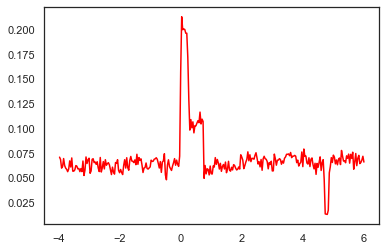

In [76]:
# plt.plot(times_use, np.mean(session.behaviour_trials[:, session.outcome=='hit', :], (0,1)), color='blue')
plt.plot(times_use, np.mean(session.behaviour_trials[:, session.outcome=='miss', :], (0,1)), color='red')
# plt.plot(times_use, np.mean(session.behaviour_trials[:, session.outcome=='fp', :], (0,1)), color='green')
# plt.plot(times_use, np.mean(session.behaviour_trials[:, session.outcome=='cr', :], (0,1)), color='black')

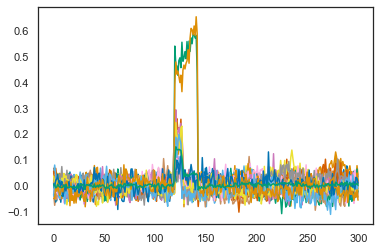

In [130]:
# plt.plot(times_use, np.mean(session.behaviour_trials[:, session.outcome=='miss', :], (0,1)), color='red')


miss = np.mean(session.behaviour_trials[:, session.outcome=='miss', :], 0)


baseline = np.mean(miss[:, :session.pre_frames], 1)
miss = np.subtract(miss.T, baseline).T
# miss = np.sort(miss, 0)

for t in miss:
    plt.plot(t)
    
plt.plot(np.mean(miss, 0))
# plt.ylim(-0.1,0.05)

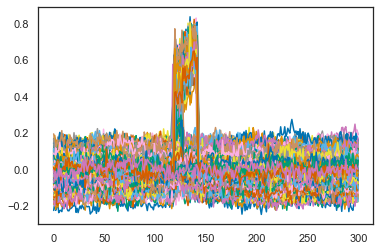

In [125]:
flu = np.mean(session.behaviour_trials, 0)
for t in flu:
    plt.plot(t)

In [124]:
session.outcome.shape

(315,)

In [113]:
np.argsort(np.min(flu, 1))

array([272,   0,   2,   4,   1,   3,   5,  14,  19,   6,  13,  35,  18,
         8,  20,   7,  12,  28,  33,  36,   9,  30,  11,  44,  10,  27,
        16,  17,  63,  29,  25,  62,  46,  40,  15,  22,  31,  21,  59,
        34,  58,  24,  26,  39,  52,  41,  23,  47,  48,  45,  38,  65,
        66,  64,  42,  50,  32,  53,  57, 100,  37,  72,  67,  56, 108,
        74,  99,  43, 124,  49,  51,  69,  61,  55,  60,  78,  68, 103,
        73,  94,  70, 110,  80,  71, 109, 102, 101,  85,  54,  81,  87,
       114, 133, 314,  91, 112,  84, 123, 315, 104, 105,  90,  83,  86,
       170,  77,  82,  76, 130, 310, 107, 121,  98, 305,  79,  75,  95,
        93,  97, 128,  92, 164, 115, 309, 160, 151,  88, 120, 166, 165,
       308,  89, 312, 118, 303,  96, 313, 106, 113, 122, 167, 116, 125,
       168, 304, 178, 300, 307, 163, 174, 169, 129, 162, 111, 311, 141,
       278, 139, 158, 138, 176, 292, 290, 294, 306, 161, 302, 119, 126,
       159, 145, 157, 171, 172, 155, 154, 152, 181, 295, 301, 17

In [63]:
def get_percent_cells_responding(session, region):

    fdr_rate = 0.1

    flu = session.behaviour_trials
    times_use = session.filter_ps_time
    
    if region == 's1':
        flu = flu[session.s1_bool, :, :]
    elif region == 's2':
        flu = flu[session.s2_bool, :, :]
    
    percent_cells_responding = []

    for trial_idx in range(flu.shape[1]):

        # Haven't built this for 5 Hz data
        assert mouse not in ['J048', 'RL048']

        trial = flu[:, trial_idx, :]

        # 500 ms before the stim with a nice 
        # juicy buffer to the artifact
        pre_idx = np.where(times_use < -0.07)[0][-15:]  

        # You can dial this back closer to the artifact if you cut out 150
        post_idx = np.logical_and(times_use > 1, times_use <= 1.5)

        pre_array = trial[:, pre_idx]
        post_array = trial[:, post_idx]

        p_vals = [stats.wilcoxon(pre, post)[1] for pre, post in zip(pre_array, post_array)]
        p_vals = np.array(p_vals)

        sig_cells, correct_pval, _, _ = multitest.multipletests(p_vals, alpha=fdr_rate, method='fdr_bh',
                                                            is_sorted=False, returnsorted=False)

        percent_cells_responding.append(sum(sig_cells))

    percent_cells_responding = np.array(percent_cells_responding) / sum(session.s2_bool) * 100
    assert len(percent_cells_responding) == flu.shape[1]
    
    return percent_cells_responding

Text(0, 0.5, 'S2 cells responding (%)')

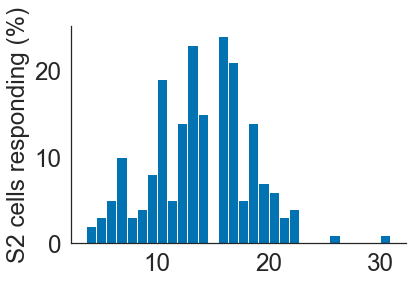

In [64]:
s2_responds = get_percent_cells_responding(session, 's2')
_ = plt.hist(s2_responds, 30)
plt.ylabel('S2 cells responding (%)')

Text(0.5, 0, 'Pupil area before trial\n(AU)')

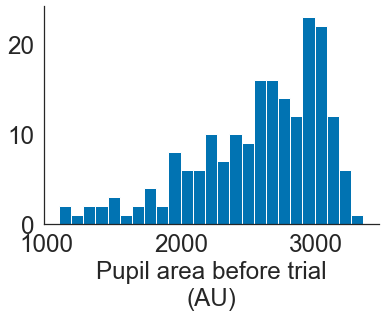

In [65]:
pupil_arr = build_flu_array_single(run, use_pupil=True, pre_frames=session.pre_frames,
                                   post_frames=session.post_frames)
pupil_arr = pupil_arr[:, session.nonnan_trials, :].squeeze()

pre_pupil = np.mean(pupil_arr[:, times_use<0], 1)
_ = plt.hist(pre_pupil, 25)
plt.xlabel('Pupil area before trial\n(AU)')

Text(0, 0.5, 'Pupil area before trial\n(AU)')

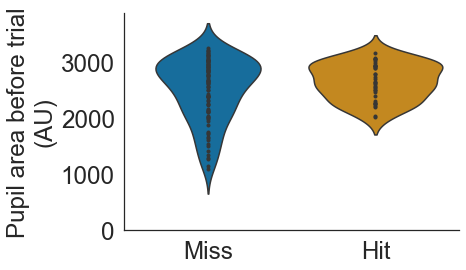

In [66]:
_ = plt.hist(pre_pupil[session.outcome=='miss'], 15, color='red')
_ = plt.hist(pre_pupil[session.outcome=='hit'], 15)

sns.violinplot(data=[pre_pupil[session.outcome=='miss'], pre_pupil[session.outcome=='hit']],
               orient='v', inner='point')
plt.xticks([0,1], ['Miss', 'Hit'])
plt.ylabel('Pupil area before trial\n(AU)')

Text(0, 0.5, 'S2 cells responding (%)')

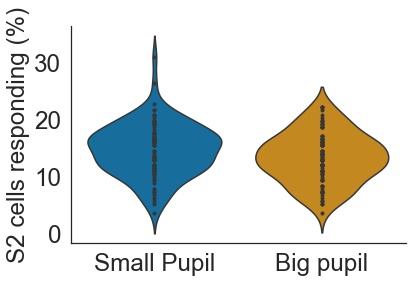

In [67]:
small = pre_pupil <= np.median(pre_pupil)
big = pre_pupil > np.median(pre_pupil)

sns.violinplot(data=[s2_responds[small], s2_responds[big]], orient='v', inner='point')
plt.xticks([0,1], ['Small Pupil', 'Big pupil'])
plt.ylabel('S2 cells responding (%)')

In [165]:
miss_pre_pupil = []
hit_pre_pupil = []

n_s2_big = []
n_s2_small = []

for run, session, pupil in zip(runs, sessions, pupils):
    s2_responds = get_percent_cells_responding(session, 's2')
    
    pupil_arr = build_flu_array_single(run, use_pupil=True, pre_frames=session.pre_frames,
                                       post_frames=session.post_frames)
    pupil_arr = pupil_arr[:, session.nonnan_trials, :].squeeze()

    pre_pupil = np.mean(pupil_arr[:, times_use<0], 1)
    
    small = pre_pupil <= np.median(pre_pupil)
    big = pre_pupil > np.median(pre_pupil)
    
    pre_pupil = stats.zscore(pre_pupil)
    hit_pre_pupil.append(pre_pupil[session.outcome=='hit'])
    miss_pre_pupil.append(pre_pupil[session.outcome=='miss'])
    
    s2_responds = get_percent_cells_responding(session, 's2')
    
    n_s2_big.append(s2_responds[big])
    n_s2_small.append(s2_responds[small])
    

hit_pre_pupil = np.concatenate(hit_pre_pupil)
miss_pre_pupil = np.concatenate(miss_pre_pupil)

n_s2_big = np.concatenate(n_s2_big)
n_s2_small = np.concatenate(n_s2_small)

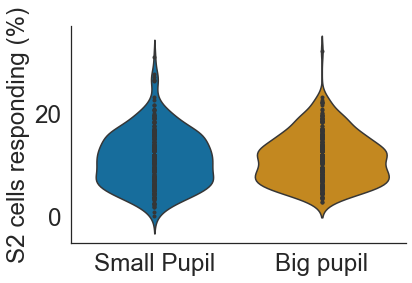

In [166]:

sns.violinplot(data=[n_s2_small, n_s2_big], orient='v', inner='point')
plt.xticks([0,1], ['Small Pupil', 'Big pupil'])
plt.ylabel('S2 cells responding (%)')

save_figure('n s2 responds _pupil')

In [167]:
stats.mannwhitneyu(n_s2_small, n_s2_big, alternative='two-sided')

MannwhitneyuResult(statistic=50914.0, pvalue=0.694519693319134)

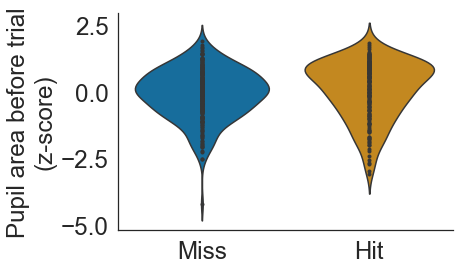

In [164]:
sns.violinplot(data=[hit_pre_pupil, miss_pre_pupil],
               orient='v', inner='point')
plt.xticks([0,1], ['Miss', 'Hit'])
plt.ylabel('Pupil area before trial\n(z-score)')
save_figure('trial pupil area')




In [163]:
stats.mannwhitneyu(hit_pre_pupil, miss_pre_pupil, alternative='two-sided')

MannwhitneyuResult(statistic=20650.0, pvalue=0.015040885609489761)

In [51]:
def lineplot_matrix(data, x_axis, color, label):

    df = pd.DataFrame(data).melt()
    df['time (seconds)'] = np.repeat(x_axis, data.shape[0])

    sns.lineplot(x='time (seconds)', y='value', data=df, color=color,
                label=label)
    

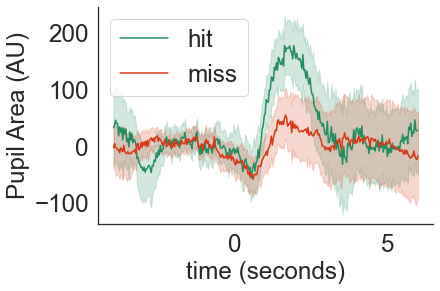

In [147]:
x_axis = session.filter_ps_time

# Baseline the pupil
baseline = np.mean(pupil_arr[:, :session.pre_frames], 1)
pupil_arr = np.subtract(pupil_arr.T, baseline).T

lineplot_matrix(data=pupil_arr[session.outcome=='hit'], x_axis=x_axis, color=COLORS[0], label='hit')
lineplot_matrix(data=pupil_arr[session.outcome=='miss'], x_axis=x_axis, color=COLORS[1], label='miss')
# lineplot_matrix(data=pupil_arr[session.outcome=='fp'], x_axis=x_axis, color='orange', label='fp')
# lineplot_matrix(data=pupil_arr[session.outcome=='cr'], x_axis=x_axis, color='pink', label='cr')
plt.ylabel('Pupil Area (AU)')
save_figure('Trial averaged pupil traces')



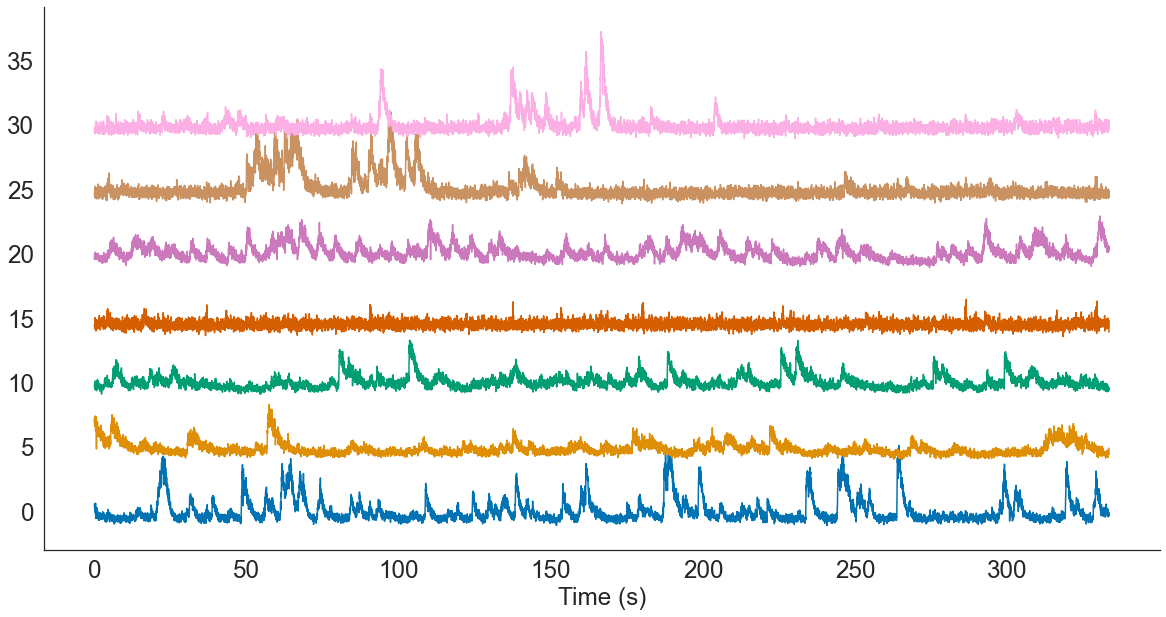

In [98]:
plt.figure(figsize=(20,10))

tp_plot = np.arange(40000, 50000)
x_axis = np.arange(len(tp_plot)) / 30
for i in range(7):
    plt.plot(x_axis, run.flu[i+23, tp_plot]+i*5)

plt.xlabel('Time (s)')
save_figure('traces')



In [102]:
def get_subset_dprime(session):
    
    assert session.trial_subsets.shape == session.outcome.shape
    
    fp_rate = sum(session.outcome=='fp') / (sum(session.outcome=='fp') + sum(session.outcome=='cr'))
    subset_dprimes = []
    for subset in [[5, 10], [20, 30], [40, 50], [150]]:
#     for subset in [[5],[10],[20],[30],[40],[50], [150]]:
        idx = np.isin(session.trial_subsets, subset)
        outcome = session.outcome[idx]
        hit_rate = sum(outcome=='hit') / (sum(outcome=='hit') + sum(outcome=='miss'))
        subset_dprimes.append(d_prime(hit_rate, fp_rate))
#         subset_dprimes.append(hit_rate)
    
    return subset_dprimes

In [114]:
subset_dprimes = [get_subset_dprime(session) for session in sessions]
subset_dprimes = np.array(subset_dprimes)

# psychometric function
def pf(x, max_value, alpha, beta):
    ''' Max value: max value of sigmoid
        alpha: x_axis midpoint
        beta: the growth rate
    '''
    return max_value / (1 + np.exp( -(x-alpha)/beta))

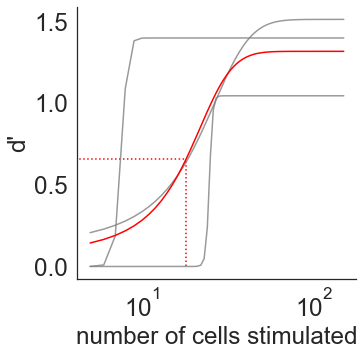

In [121]:

np.seterr(divide='ignore')  # Ugly division by 0 error
plt.figure(figsize=(5,5))

x_axis = [7.5, 25, 45, 150]
# x_axis = [5,10,20,30,40,50,150]
all_dp = []
n = 0

min_x = 5
for idx, dp in enumerate(subset_dprimes):
    
    all_dp.append(dp)
#     plt.plot(x_axis, dp, '.', color='grey', alpha=1, markersize=10)
    
    popt, pcov = curve_fit(pf, x_axis, dp, method='dogbox', p0=[max(dp), 50, 200])
    
    plt.plot(np.arange(min_x ,max(x_axis)), pf(np.arange(min_x, max(x_axis)), *popt), color='grey', alpha=0.8)
    plt.xscale('log')
    
y = np.concatenate(all_dp)
x = np.tile(x_axis, subset_dprimes.shape[0])
popt, pcov = curve_fit(pf, x, y, method='dogbox', p0=[max(y), 50, 200])
plt.plot(np.arange(min_x, max(x_axis)), pf(np.arange(min_x, max(x_axis)), *popt), color='red')

plt.xscale('log')
plt.ylabel('d\'')
plt.xlabel('number of cells stimulated', fontname='Arial')

ticks = [5, int(popt[1]), 100, 150]
ticks = [10,100]

# plt.axvline(x=popt[1], ymax=popt[0]/2, color='red', ls=':')
plt.vlines(x=popt[1], ymin=0, ymax=popt[0]/2, color='red', ls=':')
plt.hlines(y=popt[0]/2, xmin=0, xmax=popt[1], color='red', ls=':')

plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.gca().tick_params(which='minor', length=1, color='r')


save_figure('psychos')


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False,

jot
jot
jot
jot


<Figure size 7200x7200 with 0 Axes>

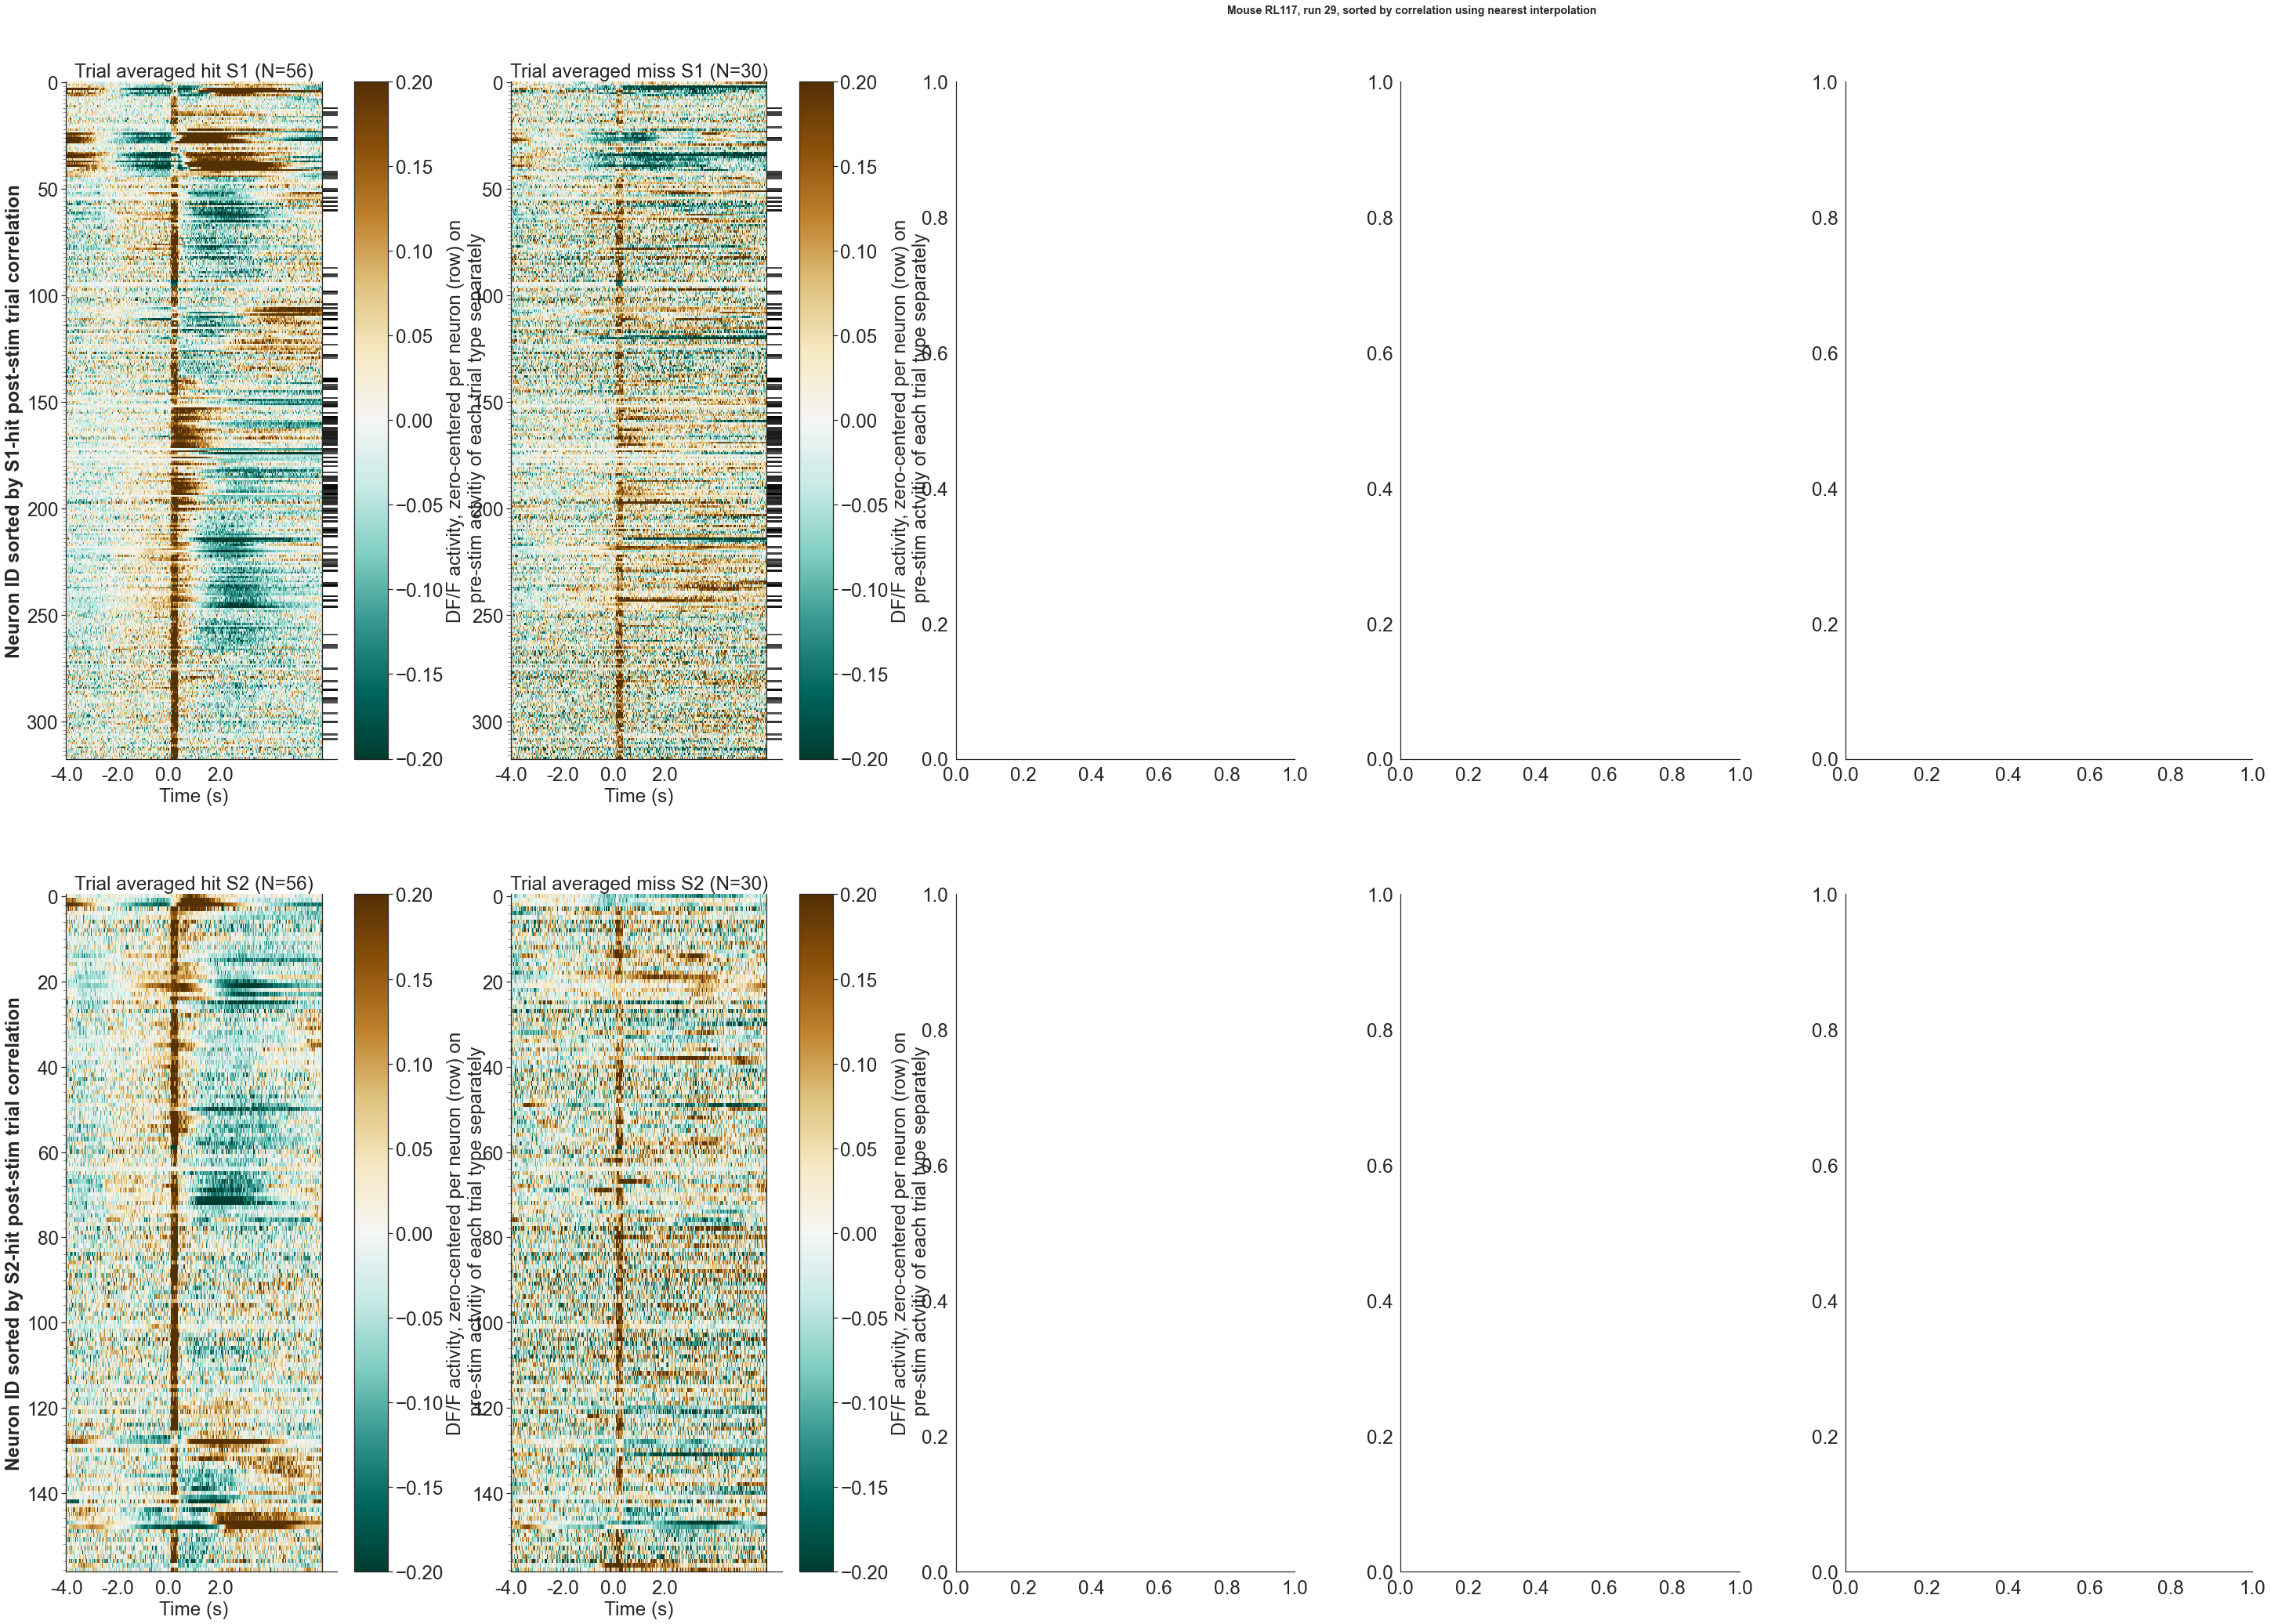

In [174]:
from pop_off_plotting import plot_raster_plots_all_trials_one_session
from pop_off_plotting import plot_raster_plots_trial_types_one_session


plt.figure(figsize=(100,100))
plot_raster_plots_trial_types_one_session(sessions[1])
save_figure('heat map')